# Task 2: Imitation Learning

## Setup Code / Packages
If you are running the code locally follow the instructions [here](../docs/setup.md).

If you are using Google Colab make sure to run the two cells below to install all dependencies and enable headless rendering. You will also need to upload your xml file to the assets folder.

In [12]:
# Install required packages for the notebook
!pip install gymnasium[mujoco]==0.29.1  # includes mujoco and mujoco-py dependencies
!pip install numpy scipy matplotlib imageio

#Mplib does not install man
!pip install mplib==0.1.1  


#Needed to install these plugins specifically
!pip install imageio[ffmpeg]
!pip install imageio[pyav]

#Download the assets folder
!git init temp-repo
%cd temp-repo
!git remote add -f origin https://github.com/triton-droids/simulation.git
!git config core.sparseCheckout true
!echo "assets/*" >> .git/info/sparse-checkout
!git pull origin onboarding
%cd ..
!mv temp-repo/assets ./assets
!rm -rf temp-repo

ERROR: Could not find a version that satisfies the requirement mplib==0.1.1 (from versions: 0.2.0a0, 0.2.0a1, 0.2.0a2, 0.2.0, 0.2.1)
ERROR: No matching distribution found for mplib==0.1.1
Initialized empty Git repository in /Users/orengershony/Projects/simulation/task2/temp-repo/.git/
/Users/orengershony/Projects/simulation/task2/temp-repo
Updating origin
remote: Enumerating objects: 930, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 930 (delta 66), reused 38 (delta 38), pack-reused 818 (from 2)
Receiving objects: 100% (930/930), 16.31 MiB | 11.85 MiB/s, done.
Resolving deltas: 100% (300/300), done.
From https://github.com/triton-droids/simulation
 * [new branch]      feature-29/controllers -> origin/feature-29/controllers
 * [new branch]      main                   -> origin/main
 * [new branch]      objects                -> origin/objects
 * [new branch]      onboarding             -> origin/onboarding
 * [new br

: 

In [7]:
# Configure MuJoCo for Colab
import os
os.environ['MUJOCO_GL'] = 'egl'  # enables headless rendering

## Using Gymnasium
No problems are assigned here, but understanding the code APIs/interfaces and functionalities are important.

### Gymnasium Basics
The Gymnasium package is a standardized API for creating and interacting with simulation environments. 

<img src="../assets/media/gym_loop.png" alt="agent-environment loop" width="500"/>

Gymnasium defines the agent-environment loop — a simple interface where an agent takes actions and receives observations, rewards, and termination signals from an environment. This loop forms the foundation for reinforcement learning (RL) and allows us to easily manipulate the simulator.

**Why We Use Gymnasium**

Gymnasium acts as a common interface layer between learning algorithms and simulation environments. It provides:
- A uniform API (reset(), step(), observation, reward, done, info) 
- Integration with RL algorithm libraries (e.g., Stable-Baselines3, CleanRL).
- Rendering and debugging utilities for visualization and evaluation.


In this task, you will use Gymnasium as the primary API to interface with the simulator to :
- Collect trajectory data for imitation learning.
- Evaluate and deploy trained policies.

Read their documentation [here](https://gymnasium.farama.org/).


## Part 0: Creating a Standardized Environment with Gymnasium
In this part, you will implement the `TrajEnv` class to wrap a MuJoCo simulation in a Gymnasium interface.

Your task is to decide which observations are useful as states in a behavior cloning setting. You will also implement the `is_grasped` property to define when the robot has successfully grasped the object and the `terminated` property to specify when the cube is in the bin. The `reset_model` method should randomize initial arm and object positions to encourage generalization.

You should step through Gymnasium functions like `do_simulation` and `set_state` to see how to control the simulator.

In [1]:
from scipy.spatial.transform import Rotation as R
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.spaces import Box
import numpy as np
import mujoco
import os

XML_PATH = os.path.abspath("assets/descriptions/DropCubeInBinEnv.xml")

class TrajEnv(MujocoEnv):
    metadata = {"render_modes": ["human", "rgb_array", "depth_array"]}

    def __init__(self, xml_file: str, frame_skip: int = 5, **kwargs):
        # TODO: Define the observation space and store any useful state variables.
        observation_space = Box(
            low=-np.inf, high=np.inf, shape=(33,), dtype=np.float32  # TODO: set correct shape
        )

        super().__init__(
            xml_file,
            frame_skip,
            observation_space=observation_space,
            **kwargs,
        )

        self.panda_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, 'panda_arm')
        self.gripper_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, 'panda_hand')
        self.cube_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, 'cube')
        self.bin_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, 'bin')
        
        

    
    @property
    def is_grasped(self):
        gripper_pos = self.data.body(self.gripper_id).xpos
        cube_pos = self.data.body(self.cube_id).xpos

        return np.linalg.norm(gripper_pos - cube_pos) < 0.05
        # TODO: Implement a condition to determine if the object
        # is grasped. Could use distance between gripper and object, contact forces, etc.
        pass

    @property
    def terminated(self):
        # TODO: Define the termination condition for an episode.
        pass
    
    def _get_obs(self):
        # TODO: Return the observations selected for the environment state
        # Example: joint positions, velocities, end-effector pose, object positions
        pass

    def step(self, action: np.ndarray) -> tuple[np.ndarray, bool, bool]:
        # DO NOT MODIFY THIS FUNCTION
        self.do_simulation(action, self.frame_skip)
        obs = self._get_obs()
        terminated = self.terminated

        if self.render_mode == "human":
            self.render()

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        return obs, None, terminated, False, None

    def reset_model(self):
        print(f"Number of keyframes: {self.model.nkey}")
        print(f"Available keyframes: {[self.model.key(i).name for i in range(self.model.nkey)]}")

        self.default_qpos = np.array(
                self.model.keyframe('home').qpos,
                dtype=np.float32
            )

        qpos = self.default_qpos.copy()
        qvel = np.zeros(self.model.nv)

        # TODO: Randomize initial positions for the arm (9 joints) and objects
        # to create diverse starting conditions. Ensure valid states and objects are not overlapping.
        

        self.set_state(qpos, qvel)
        return self._get_obs()



To understand what is happening in the environment, you can call `env.render()` to visualize it.  
Since we set `render_mode="rgb_array"`, `env.render()` will return an RGB array that can be displayed.  


> **Note:** If the default view of the environment is not ideal, you may need to adjust the camera.  
> You can do this by defining a camera in your Mujoco XML file and then passing its name as a kwarg to the `TrajEnv` constructor via the `camera_name` argument.


If you are on colab you can render the environment like so. If you are running MuJoCo locally you can use `render_mode="human"` to display viewing window.


Number of keyframes: 1
Available keyframes: ['home']


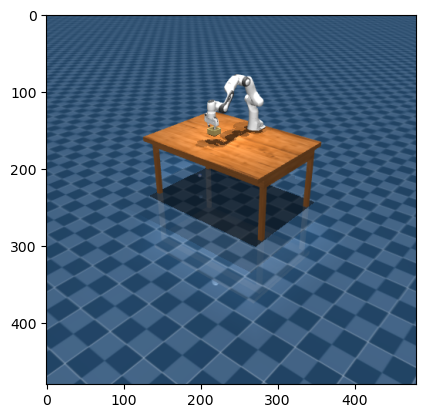

In [2]:
from gymnasium.wrappers import TimeLimit
import matplotlib.pyplot as plt


env = TrajEnv("../assets/descriptions/DropCubeInBinEnv.xml", 20, render_mode='rgb_array', camera_name="fixed")
env = TimeLimit(env, 100)
env.reset()
image = env.render() 
image = image
plt.imshow(image)

With these core functionalities we can build the basic interaction loop that consists of a reset followed by steps until terminated or truncated is True. We can also record a video as well.

In [3]:
obs, _ = env.reset()
done = False
images = [env.render()]
# keep taking steps until either we terminated or truncate
while not done:
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    images.append(env.render())
    done = terminated or truncated

Number of keyframes: 1
Available keyframes: ['home']


In [10]:
from IPython.display import Video
import imageio

frames = images 
frames = [frame.astype(np.uint8) for frame in frames]   

# Write video to file
video_path = "output_video.mp4"
with imageio.get_writer(video_path, fps=20) as writer:
    for frame in frames:
        writer.append_data(frame)

# Display video in notebook
Video(video_path, embed=True)

We will now try and control the robot to grasp the cube, pick it up, and drop it in the wooden bin. 

The following code sets up a motion planning library for you and saves some useful variables. 
- `planner`: The planner objects uses screw motion planning.
- `panda_hand_tcp`: The panda hand tool center point "link", which gives the current pose of the link we are controlling via the motion planning library. This is the point in the middle between the two panda arm grippers.
- `cube`: The cube object, which you can use to acccess its pose.
- `bin`: The bin object.

The motion planner setup will generate a sequence joint position actions for all the joints excluding the gripper. The gripper actions you can manually pick (can range from 0 to 255). 

In [11]:
import mplib
import os

env = TrajEnv(
    xml_file=XML_PATH, 
    frame_skip=20,
    render_mode="rgb_array"
    
)
env.reset(seed=42)

link_names = [
    'panda_link0','panda_link1','panda_link2','panda_link3','panda_link4',
    'panda_link5','panda_link6','panda_link7','panda_link8','panda_hand',
    'panda_hand_tcp','panda_leftfinger','panda_rightfinger',
    'panda_leftfinger_pad','panda_rightfinger_pad'
]
joint_names = [
    'panda_joint1','panda_joint2','panda_joint3','panda_joint4',
    'panda_joint5','panda_joint6','panda_joint7','panda_finger_joint1','panda_finger_joint2'
]

planner = mplib.Planner(
    urdf=os.path.abspath("assets/descriptions/panda/urdf/panda.urdf"),
    srdf=os.path.abspath("assets/descriptions/panda/urdf/panda.srdf"),
    user_link_names=link_names,
    user_joint_names=joint_names,
    move_group="panda_hand_tcp",
    joint_vel_limits=np.ones(7) * 0.8,
    joint_acc_limits=np.ones(7) * 0.8,
)

# this sets the planner object up such that you can plan with poses in the world frame, which is the default frame of all pose data
# in our simulator
planner.set_base_pose(np.concatenate([env.data.xpos[env.panda_id], env.data.xquat[env.panda_id]]))

ModuleNotFoundError: No module named 'mplib'

**Notes for this task**

The goal is to use the motion planner to pick up the cube and drop it into the bin.

- You will need to access object positions and orientations from the simulator (env.data.xpos, env.data.xquat, etc.).
- The motion planner requires a target pose (7,) for the robot hand (position + quaternion) and the current joint configuration (qpos). Both are expressed in the world frame.
- Plan a trajectory to a consistent grasp pose above the cube, execute it while keeping the gripper open, then move down and close the gripper to pick up the cube.    
- Finally, open the gripper to release the cube into the bin.

The planner may fail if the pose is unreachable, collides with the environment, or the solver does not converge. This is expected—adjust poses or retry if needed.

In [ ]:
from gymnasium.wrappers import RecordVideo

EPISODES = 10

env = TrajEnv(
    xml_file=XML_PATH, 
    frame_skip=20,
    render_mode = "rgb_array"
)
env = RecordVideo(
    env,
    "videos",                       # folder to save videos
    episode_trigger=lambda e: True,  # record every episode
    name_prefix="planner"
    )

def pick_cube_solution(env, episode_data=None):
    # TODO Use the planner to pick up the cube and drop it in the bin.

    result = planner.plan_screw(
        target_pose=???,           # target hand pose above cube (7,)
        qpos=???,                  # current robot joint positions (9,)
        time_step=env.dt,
    )

    # Follow the generated plan while keeping the gripper open (1)
    if result["status"] == "Success":
        for pos in result["position"]:
            env.step(np.concatenate([pos, [255]]))
    else:
        print(f"Planner failed: {result}")
        return False  # Signal failure
    
    return True


successes = 0
for i in range(EPISODES):
    env.reset(seed=i)
    pick_cube_solution(env) 

    success = env.terminated
    successes += success
env.close()
print(f"Success rate: {successes/EPISODES}")

In [ ]:
from IPython.display import Video
Video("videos/planner-episode-0.mp4", embed=True, width=320) # Watch replay

## Part 1: Collect your Imitation Learning Dataset


Now that you’ve used the motion planner to complete a single pick-and-place sequence, the next step is to repeat this process many times to collect a dataset for imitation learning.

In imitation learning, the dataset is made of trajectories—sequences of state-action pairs showing how an expert (in this case, the motion planner) solves the task. Each trajectory will later be used to train a policy that imitates this behavior.

>**Tip**: Standardizing the orientation and approach of the gripper will help the robot pick up the cube in the same way each time, resulting in a more reliable model.


In [ ]:
import pickle

env = TrajEnv(
    xml_file=XML_PATH, 
    frame_skip=20,
)

trajectories = []

EPISODES = 10_000
success_count = 0

for i in range(EPISODES):
    env.reset()
    episode_data = []

    # this sets the planner object up such that you can plan with poses in the world frame.
    planner.set_base_pose(np.concatenate([env.data.xpos[env.panda_id], env.data.xquat[env.panda_id]]))

    result = pick_cube_solution(env, episode_data)


    if result:
        trajectories.append(episode_data)
        print(f"Episode {i} completed successfully.")
        success_count += 1
    
    
# ===== Save dataset =====
with open("pick_place_dataset.pkl", "wb") as f:
    pickle.dump(trajectories, f)

print(f"Success rate: {success_count / EPISODES}")
print(f"Total trajectories: {len(trajectories)}")
env.close()

## Part 2: Create Behavior Cloning Dataset

Using the trajectory data you have collected in the previous task, complete the `TrajectoryDataset` class to feed your model. 

>**NOTE**: The model learns to map states to actions, so the order of the data is not important. You can flatten all episodes and sample from any step freely.

In [ ]:
from torch.utils.data import Dataset
import pickle

class TrajectoryDataset(Dataset):
    def __init__(self, data):
        pass

    def __len__(self):
        pass

    def __getitem__(self, idx):
        #This should return observation idx and action idx
        pass


dataset_file = "pick_place_dataset.pkl"
with open(dataset_file, "rb") as f:
    data = pickle.load(f)
dataset = TrajectoryDataset(data)

## Part 3: Define the Policy Network

In this step, you will implement a behavior cloning policy network. The goal of this network is to learn to map observations (states) to actions by imitating the trajectories you collected earlier. 

**NOTE**: See [tips](tips.md) for guidance on designing your network architecture and BC overview.

In [ ]:
import torch.nn as nn

class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        #TODO: Define the network architecture
        # Start with a basic MLP and experiment with different architectures
        pass

    def forward(self, x):
        pass

## Part 4: Training Loop
You will train the neural network policy to imitate expert behavior.

We’ve provided an `eval_policy` function to test your actor in simulation. It runs several episodes and reports a success rate, so you can track how well your policy performs as training progresses.

In [22]:
import gymnasium as gym
import torch.nn as nn
import numpy as np
import torch

def eval_policy(eval_env: gym.Env, actor: nn.Module, num_episodes: int = 5):
    success = 0
    for ep in range(num_episodes):
        obs, _ = eval_env.reset()
        terminated, truncated = False, False
        
        while not (terminated or truncated):
            with torch.no_grad():
                action, _ = actor(torch.from_numpy(obs).float())
            obs, _, terminated, truncated, _ = eval_env.step(action.cpu().numpy())

        if terminated:
            success += 1
        
        print(f"Episode {ep+1}: Success={terminated}")
    return success / num_episodes

In [ ]:
from torch.utils.data import DataLoader
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
np.random.seed(0)

actor = Actor().to(device)
eval_env = TrajEnv(XML_PATH, 20)

batch_size = 1024
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

lr = 3e-5
epochs = 100

def nll_loss(actor: nn.Module, obs: torch.Tensor, expert_actions: torch.Tensor):
    mean, log_std = actor(obs)
    std = log_std.exp()
    dist = torch.distributions.Normal(mean, std)
    log_prob = dist.log_prob(expert_actions).sum(-1)   #sum over action dims
    loss = -log_prob.mean()
    return loss

# TODO: Write the training loop
# Train the actor policy to predict the actions in the dataset.
# Make sure to run the eval_policy function every once in a while to track training progress
# and save your best policy checkpoint to be loaded later for evaluation. 
# If you are confident in your model, sometimes a different seed can work. 
# Training time depends on number of samples and number of epochs, but should not take more than 10 minutes on google colab.


## Part 5: Evaluate in Simulator
Time to evaluate your model. You may notice that it doesn’t succeed very often and may behave unpredictably or erratically. 

Can you think about why this might happen?

In [ ]:
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
np.random.seed(0)

eval_env = TrajEnv(XML_PATH, 20, render_mode='rgb_array')
eval_env = RecordVideo(
    eval_env,
    "videos",                       # folder to save videos
    episode_trigger=lambda e: True,  # record every episode
    name_prefix="bc-model"
    )
actor = Actor().to(device)

state_dict = torch.load('best_policy.pth')
actor.load_state_dict(state_dict)

#Evaluation
eval_policy(eval_env, actor, 5)
eval_env.close()

In [ ]:
from IPython.display import Video
Video("videos/bc-model-episode-0.mp4", embed=True, width=320) # Watch our replay